In [2]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM

model_id = "stanfordnlp/backpack-gpt2"
config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, config=config, trust_remote_code=True)
model.eval()

/home/piyush/anaconda3/envs/srinath/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/piyush/anaconda3/envs/srinath/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


BackpackGPT2LMHeadModel(
  (backpack): BackpackGPT2Model(
    (gpt2_model): GPT2Model(
      (wte): Embedding(50264, 768)
      (wpe): Embedding(512, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (sense_network): BackpackSenseNetwork(
      (dropout): Dropout(p=0.1, inplace=False)
      

In [3]:
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
import torch
import os
import matplotlib.pyplot as plt

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2",pad_token = '<pad>')

# Removing Gender Bias

## Sentence 1

In [177]:
x = tokenizer(tokenizer.bos_token+" My wife said that",return_tensors='pt')['input_ids']  # Tokenizing

In [178]:
contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)

### without control

In [179]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [180]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'The first and she she'

In [181]:
y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)

In [182]:
he_token = tokenizer.encode(" he")
she_token = tokenizer.encode(" she")

In [183]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [184]:
p_he_she

tensor([0.0608], grad_fn=<ExpBackward0>)

### with control

In [185]:
weights= torch.ones_like(contextualization)
weights[:,10,:,:]= 0  # making the weight corresponding to 10th senses zero

In [186]:
contextualization=contextualization*weights

In [187]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [188]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'Introduction name is he he'

In [189]:
y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)

In [190]:
he_token = tokenizer.encode(" he")
she_token = tokenizer.encode(" she")

In [191]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [192]:
p_he_she

tensor([215.7316], grad_fn=<ExpBackward0>)

## Sentence 2

In [29]:
x = tokenizer(tokenizer.bos_token+" The CEO believes that",return_tensors='pt')['input_ids']  # Tokenizing

In [30]:
contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)

### without control

In [31]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [32]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'The New of the the'

In [33]:
y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)

In [34]:
he_token = tokenizer.encode(" he")
she_token = tokenizer.encode(" she")

In [35]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [36]:
p_he_she

tensor([4.9191], grad_fn=<ExpBackward0>)

### with control

In [37]:
weights= torch.ones_like(contextualization)
weights[:,10,:,:]= 0  # making the weight corresponding to 10th senses zero

In [38]:
contextualization=contextualization*weights

In [39]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [40]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'Introduction he of the he'

In [17]:
y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)

In [18]:
he_token = tokenizer.encode(" he")
she_token = tokenizer.encode(" she")

In [19]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [20]:
p_he_she

tensor([5.3106], grad_fn=<ExpBackward0>)

# control vs probability

## Sentence 1

In [5]:
def prob_ratio(x,p):
    contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
    contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)
    weights= torch.ones_like(contextualization)
    weights[:,10,:,:]= p  # making the weight corresponding to 10th senses zero
    contextualization=contextualization*weights
    y = model.run_with_custom_contextualization(x,contextualization).logits.detach()
    y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)
    he_token = tokenizer.encode(" he")
    she_token = tokenizer.encode(" she")
    p_he_she = torch.exp(y[0,he_token]-y[0,she_token])
    return p_he_she

In [194]:
x = tokenizer(tokenizer.bos_token+" My husband said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

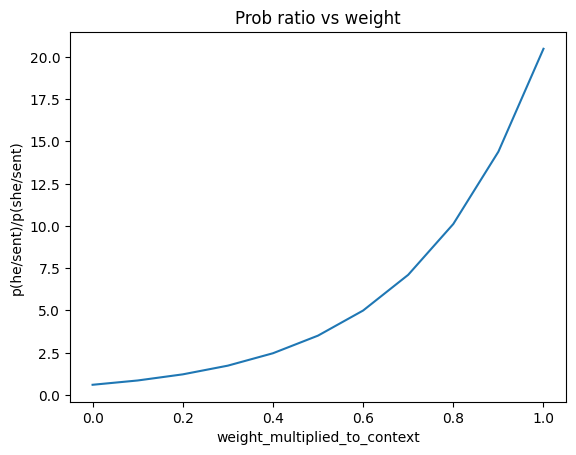

In [195]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [196]:
x = tokenizer(tokenizer.bos_token+" My wife said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

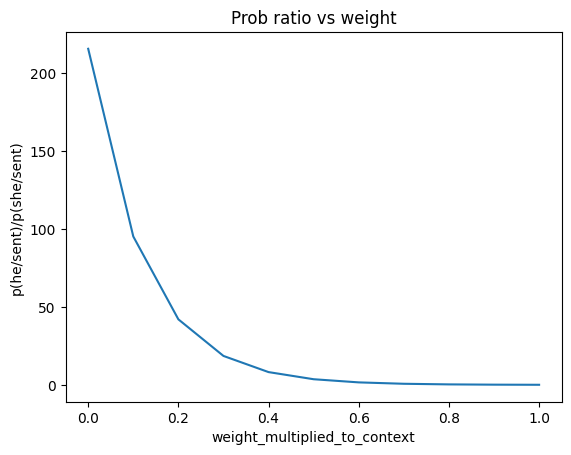

In [160]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [94]:
x = tokenizer(tokenizer.bos_token+" The CEO of the company said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

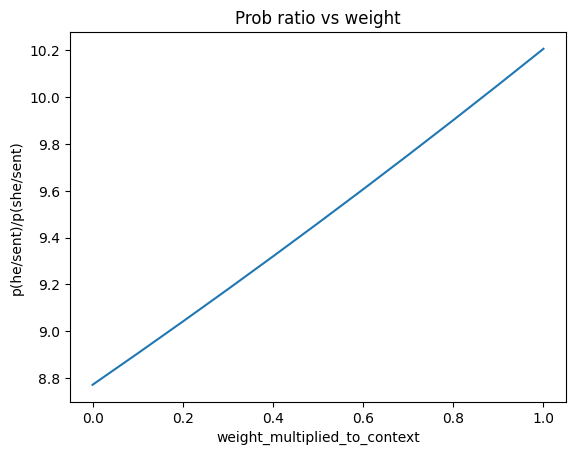

In [95]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [96]:
x = tokenizer(tokenizer.bos_token+" The Nurse said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

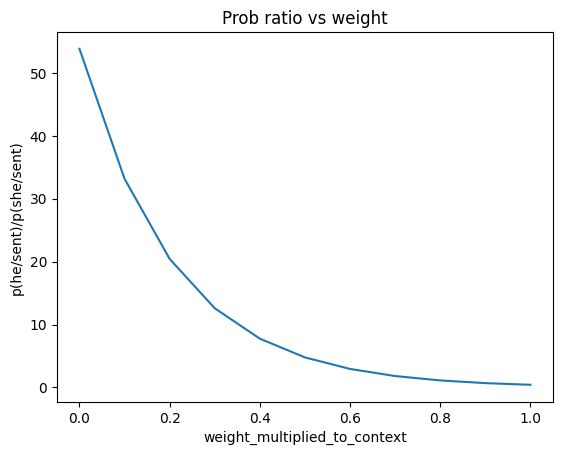

In [97]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [98]:
x = tokenizer(tokenizer.bos_token+" The Doctor said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

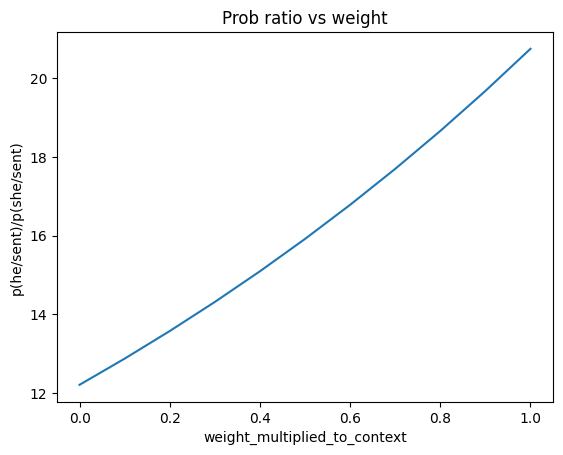

In [99]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [120]:
x = tokenizer(tokenizer.bos_token+" The teacher said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

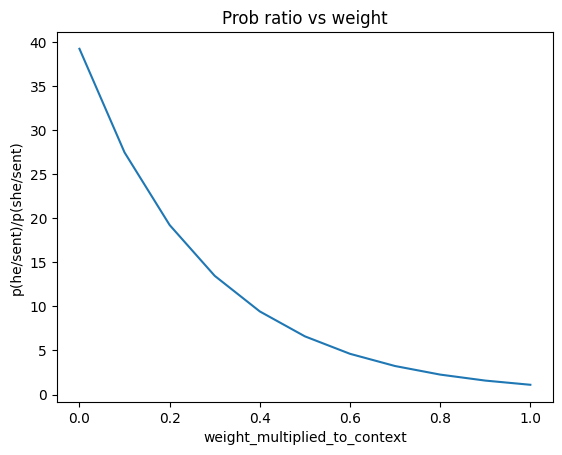

In [121]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [122]:
x = tokenizer(tokenizer.bos_token+" The developer said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

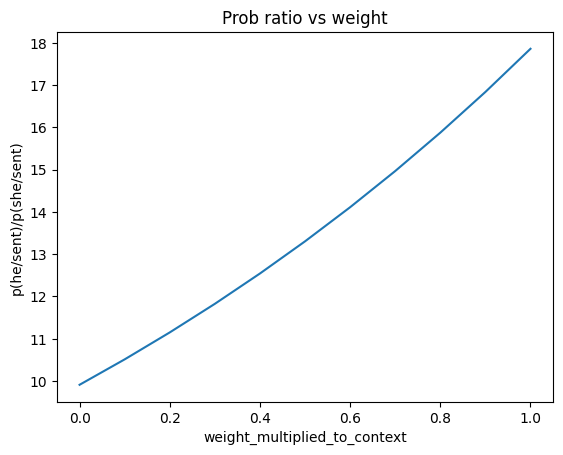

In [123]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [6]:
x = tokenizer(tokenizer.bos_token+" The pilot said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

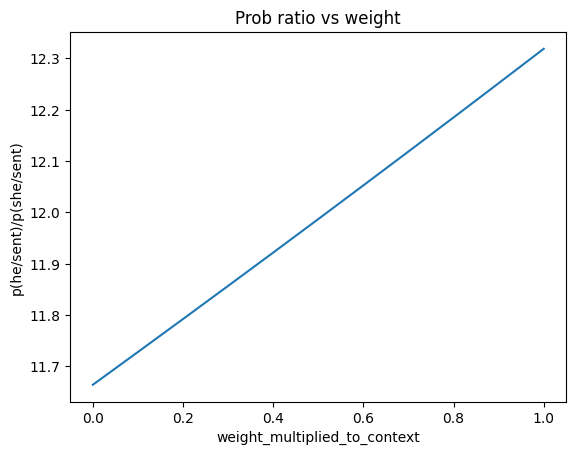

In [7]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()